# Control del doble integrador

In [1]:
import numpy as np
import control as ctrl
from matplotlib import pyplot as plt

In [2]:
s = ctrl.TransferFunction.s

G = 1/s**2
T = 1

H = ctrl.sample_system(G,Ts=T,method='zoh')
print('Sistema discretizado ',H)

Sistema discretizado  <TransferFunction>: sys[4]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1

   0.5 z + 0.5
  -------------
  z^2 - 2 z + 1


# Control proporcional

(-1.0, 1.0)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


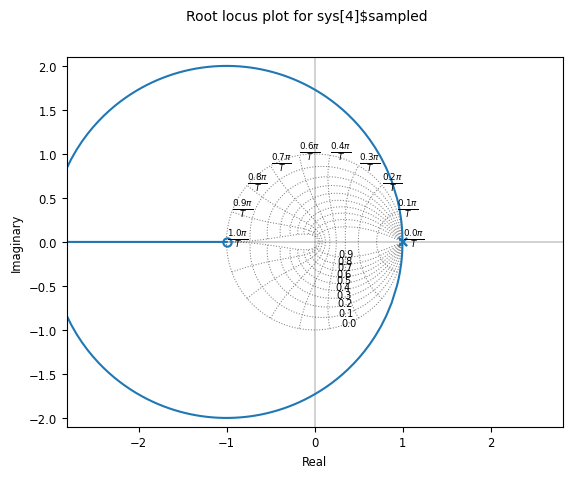

In [3]:
# Primero vemos el rootlocus
_ = ctrl.root_locus(H)
plt.xlim(-1,1)

# Da inestable siempre!
# Lo que es esperable, ya que el doble integrador necesita un término de amortiguamiento aún en el sistema continuo

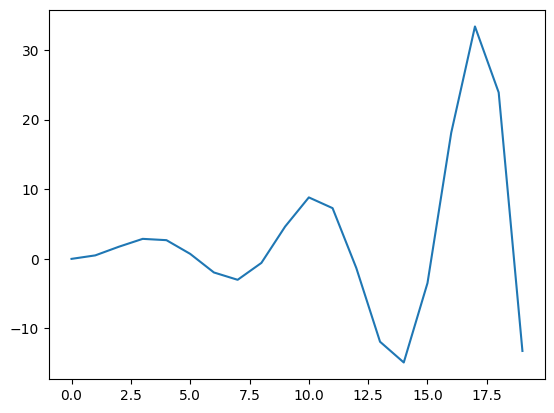

In [44]:
Hcl = ctrl.feedback(H,1)
t,y = ctrl.step_response(Hcl)
plt.plot(t,y)

# Control PD

Realimentamos posición y velocidad por ejemplo

El controlador es

$$ u_k = K_p (r_k-y_k) - K_p T_d \dot{y}_k$$

Tengo aceleración que integrado da velocidad que integrado da posición. La entrada es la aceleración. Por lo que la derivada de la velocidad es u
$$\frac{d\dot{y}}{dt} = u$$
Como $u(t)$ es constante durante el intervalo de muestreo (recordemos que es la salida de nuestro control digital)
$$\dot{y}_{k+1}-\dot{y}_{k} = u_k$$

Resulta:
$$ \dot{y}_k =\frac{1}{q-1} u_k$$

Reemplazando en la ley de control:
$$ u_k = K_p (r_k-y_k) - K_p T_d \frac{1}{q-1} u_k$$
Agrupamos $u_k$ e $y_k$
$$ (1+ K_p T_d \frac{1}{q-1}) u_k  = K_p e_k $$
$$ \frac{q-1 + K_p T_d}{q-1} u_k  = K_p e_k $$
Despejamos el controlador
$$ C(q) = K_p \frac{q-1}{q-1 + K_p T_d}   $$

Recordando el operador transferencia de la planta
$$ G(q) =\frac{0.5(q+1)}{(q-1)^2}$$

Y el operador transferencia del camino directo es
$$ CG(q) = K_p\frac{0.5(q+1)}{(q-1)(q-1 + K_p T_d)} $$

Notar que si $K_p=1$ y $T_d=1.5$ estamos frente a un deadbeat

Ganancia: 0.5
Polos de lc: [1. +0.j  0.5+0.5j 0.5-0.5j]
Ceros: [ 1.+0.j -1.+0.j] 
Controlador:  
0.5 z - 0.5
-----------
 z - 0.25

dt = 1

1 states have been removed from the model
Sistema de lazo cerrado:  
0.25 z + 0.25
-------------
z^2 - z + 0.5

dt = 1

Ganancia: 0.75
Polos de lc: [1.  +0.j        0.25+0.4330127j 0.25-0.4330127j]
Ceros: [ 1.+0.j -1.+0.j] 
Controlador:  
0.75 z - 0.75
-------------
  z + 0.125

dt = 1

1 states have been removed from the model
Sistema de lazo cerrado:  
 0.375 z + 0.375
------------------
z^2 - 0.5 z + 0.25

dt = 1

Ganancia: 1
Polos de lc: [ 1.00000000e+00+0.j -2.10734244e-08+0.j  2.10734241e-08+0.j]
Ceros: [ 1.+0.j -1.+0.j] 
Controlador:  
 z - 1
-------
z + 0.5

dt = 1

1 states have been removed from the model
Sistema de lazo cerrado:  
        0.5 z + 0.5
----------------------------
z^2 + 2.22e-16 z - 4.441e-16

dt = 1

Ganancia: 1.25
Polos de lc: [-0.80901699+0.j  1.        +0.j  0.30901699+0.j]
Ceros: [ 1.+0.j -1.+0.j] 
Controlador:  
1.25

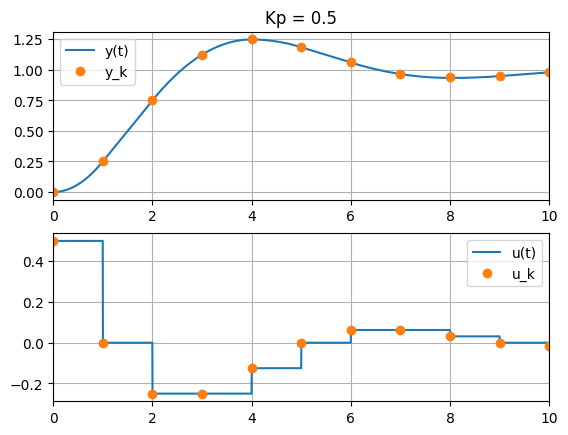

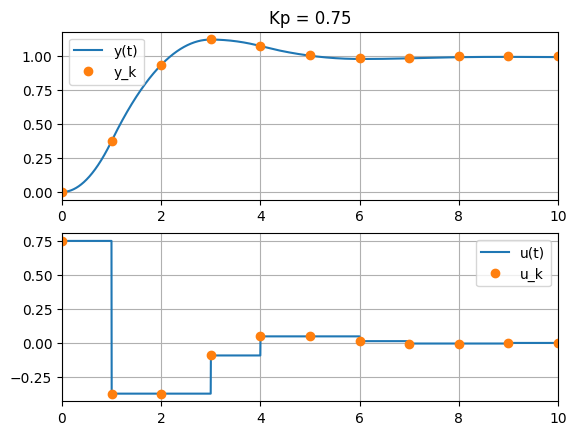

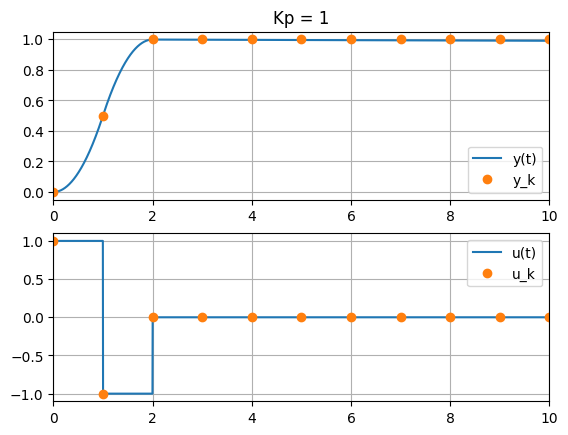

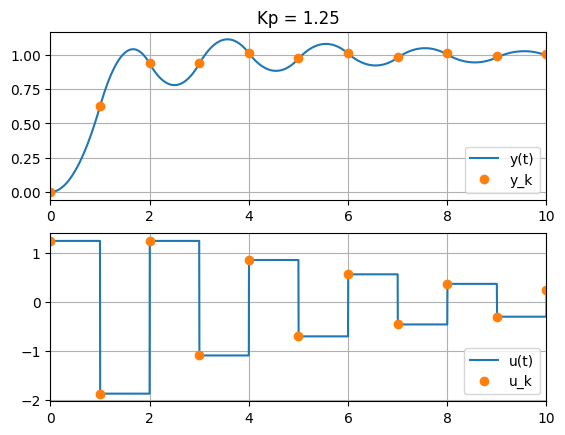

In [ ]:


Kp = [0.5,0.75,1,1.25]
Td = 1.5
r = 1
i = 0
for kp in Kp:
    i+=1
    C = ctrl.TransferFunction([kp,-kp],[1,(kp*Td-1)],dt=T)        
    Hcl = ctrl.feedback(C*H,1)
    poles,zeros = ctrl.pzmap(Hcl,plot=False)
    print(f"Ganancia: {kp}\nPolos de lc: {poles}\nCeros: {zeros} ")
    print("Controlador: ",C)
    print("Sistema de lazo cerrado: ",ctrl.minreal(Hcl))

    t,y = ctrl.step_response(Hcl,T=10)
    t,u = ctrl.forced_response(C,U=r-y,T=t)
    
    # Armo los vectores para excitar el sistema de tiempo continuo (a ver qué pasa!)
    # Tengo que extender la cantidad de muestras para emular un ZOH 
    Nc=500
    u_zoh = np.repeat(u, Nc)[:-1]
    delta_t = 1/Nc
    t_u = np.linspace(t[0],t[-1]+1-delta_t,len(u_zoh))
    tc, yc = ctrl.forced_response(G, T=t_u, U=u_zoh)
    

    plt.figure(i)
    plt.subplot(211)
    plt.plot(tc,yc,label="y(t)")
    plt.plot(t,y,'o',label=f"y_k")
    plt.legend()
    plt.xlim(0,10)
    plt.grid()
    plt.title(f"Kp = {kp}")
    plt.subplot(212)
    #plt.step(t,u,where='post',label=f"Kp={kp}")
    plt.plot(t_u,u_zoh,label='u(t)')
    plt.plot(t,u,'o',label='u_k')
    plt.grid()
    plt.xlim(0,10)
    plt.legend()


# Oscilaciones ocultas

Aplicamos otro tipo de control
Sea 
$$ H(q)= 0.5\frac{q+1}{(q-1)^2}=0.5\frac{q+1}{q^2-2q+1} = 0.5  \frac{q^{-1}+q^{-2}}{1-2q^{-1}+q^{-2}}$$

Entonces
$$y_k - 2 y_{k-1}+ y_{k-2} = 0.5 u_{k-1} + 0.5 u_{k-2}$$

Si hacemos $y_k = r_{k-1}$ estamos pidiendo que la salida iguale a la referencia en 1 solo paso (más no podemos pedir!)

$$r_{k-1} - 2 y_{k-1}+ y_{k-2} = 0.5 u_{k-1} + 0.5 u_{k-2}$$

Expresamos en función del operador desplazamiento

$$q^{-1}r_{k} - (2 q^{-1} - q^{-2}) y_{k} = 0.5 (q^{-1}+q^{-2}) u_{k}$$

Multiplicamos todo lo $q^2$

$$q r_{k} - (2 q - 1) y_{k} = 0.5 (q+1) u_{k}$$

y despejamos la acción de control para cumplir con esta meta

$$u_k = \frac{2q}{q+1} r_{k} - \frac{2(2 q - 1)}{q+1} y_{k} $$




Control FF: 
 2 z
-----
z + 1

dt = 1

Control FB: 
4 z - 2
-------
 z + 1

dt = 1

2 states have been removed from the model
Sistema de lazo cerrado: 
              z
-----------------------------
z^2 - 3.109e-15 z + 8.882e-16

dt = 1



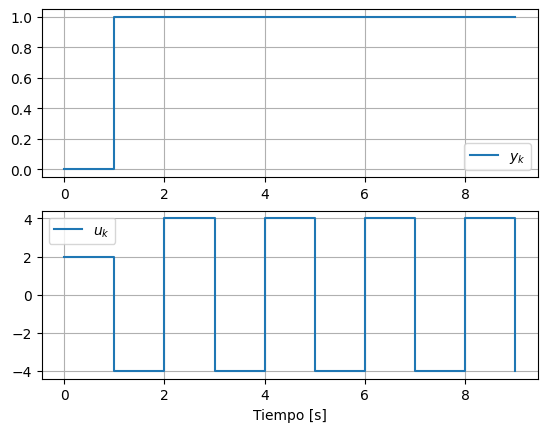

In [ ]:
Cff = ctrl.TransferFunction([2, 0],[1, 1],dt=1)
Cfb = ctrl.TransferFunction([4, -2],[1, 1],dt=1)
print("Control FF:",Cff)
print("Control FB:",Cfb)

Hcl = ctrl.minreal(Cff*ctrl.feedback(H,Cfb))
print("Sistema de lazo cerrado:",Hcl)

# Esto es prácticamente z^-1, lo que verifica la estrategia de control
# La probamos sobre el sistema 
Tfin=10
tk = np.arange(0,Tfin)
rk = np.ones_like(tk)

t,yk = ctrl.forced_response(Hcl,U=rk,T=tk)
plt.subplot(211)
plt.step(t,yk,where='post',label='$y_k$')
plt.grid()
plt.legend()

t,uff = ctrl.forced_response(Cff,U=rk,T=tk) 
t,ufb = ctrl.forced_response(Cfb,U=yk,T=tk)
uk = uff-ufb
plt.subplot(212)
plt.step(t,uk,label='$u_{{k}}$',where='post')
#plt.step(t,uff,label='$u_{{ff}}',where='post')
#plt.step(t,ufb,label='$u_{{fb}}',where='pos

t,yk = ctrl.forced_response(Hcl,U=rk,T=tk)
plt.subplot(211)
plt.step(t,yk,where='post',label='$y_k$')
plt.grid()t')
plt.xlabel('Tiempo [s]')
plt.grid()
plt.legend()

Anda muy bien en cuanto a la respuesta, pero la señal $u_k$ tiene una naturaleza oscilatoria. Veamos qué significa esto en cuanto al comportamiento del sistema de tiempo continuo

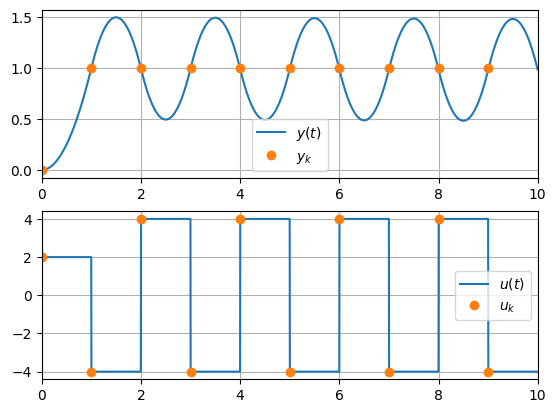

In [40]:
Nc=500
u_zoh = np.repeat(uk, Nc)[:-1]
delta_t = 1/Nc
tc = np.linspace(tk[0],tk[-1]+1-delta_t,len(u_zoh))
tc, yc = ctrl.forced_response(G, T=tc, U=u_zoh)

plt.subplot(211)
plt.plot(tc,yc,label="$y(t)$")
plt.plot(tk,yk,'o',label="$y_k$")
plt.legend()
plt.xlim(0,10)
plt.grid()
plt.subplot(212)
plt.plot(tc,u_zoh,label='$u(t)$')
plt.plot(tk,uk,'o',label='$u_k$')
plt.grid()
plt.xlim(0,10)
plt.legend()

Conclusión: tenemos oscilaciones ocultas
El sistema de tiempo continuo la está pasando mal. Si bien el sistema muestreado exhibe un comportamiento perfecto en cuanto a la salida, la señal de control está introduciendo oscilaciones no deseadas (y no observables en el discreto)

Tenemos que

$$u_k = \frac{2q}{q+1} r_{k} - \frac{2(2 q - 1)}{q+1} y_{k} $$
$$ y_k = \frac{0.5(q+1)}{(q-1)^2} u_k$$

Reemplazando $u_k$ en la segunda
$$ y_k = \frac{0.5\cancel{(q+1)}}{(q-1)^2} \frac{2q}{\cancel{q+1}} r_{k} -\frac{0.5\cancel{(q+1)}}{(q-1)^2}  \frac{2(2 q - 1)}{\cancel{q+1}} y_{k}$$

Por lo que queda clara la cancelación del polo con el cero en $-1$, que es un lugar complicado
Esto hace invisible el comportamiento oscilatorio en el sistema discreto (lo convierte en no observable)
